In [1]:
import math
# import pandas_datareader as web
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from datetime import date
import time
import warnings
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
import tensorflow as tf
from keras.layers import Dropout
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV

In [3]:
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

In [4]:
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

In [5]:
df = load_data('AMZN')

[*********************100%***********************]  1 of 1 completed


In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,311.549988,312.980011,310.010010,310.350006,310.350006,2048000
1,2015-01-02,312.579987,314.750000,306.959991,308.519989,308.519989,2783200
2,2015-01-05,307.010010,308.380005,300.850006,302.190002,302.190002,2774200
3,2015-01-06,302.239990,303.000000,292.380005,295.290009,295.290009,3519000
4,2015-01-07,297.500000,301.279999,295.329987,298.420013,298.420013,2640300


In [7]:
#get the number of rows and columns
df.shape

(1843, 7)

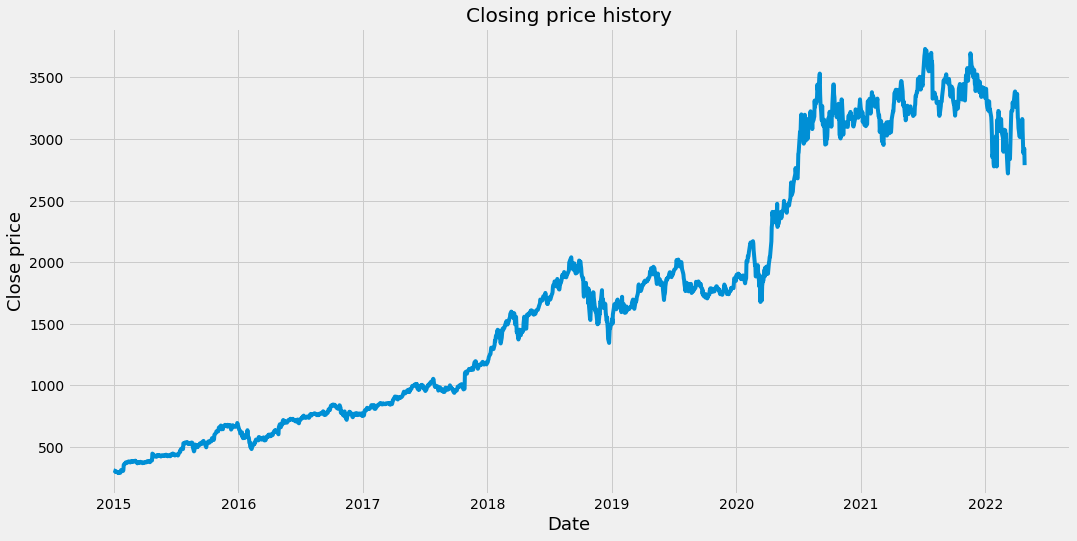

In [8]:
#visualize the closing price
plt.figure(figsize=(16,8))
plt.title('Closing price history')
# plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.plot(df['Date'], df['Close'])
# plt.xticks(range(0, df.shape[0], 200), df['Date'].loc[::365], rotation=35)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price', fontsize=18)
plt.show()

In [9]:
#Create a new DF with only Closing prices
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)* 0.8)

training_data_len

1475

Scale the data

In [10]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00679352],
       [0.00626222],
       [0.00442449],
       ...,
       [0.75484984],
       [0.76486011],
       [0.72605579]])

Create Training Dataset

In [11]:
#Create the training dataset
train_data = scaled_data[0:training_data_len, :]
#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<=61:
    print(x_train)
    print(y_train)
    print()

[array([0.00679352, 0.00626222, 0.00442449, 0.00242128, 0.00332999,
       0.00392223, 0.0028974 , 0.00129483, 0.0022616 , 0.00183482,
       0.        , 0.00110031, 0.0007229 , 0.00299031, 0.00678481,
       0.00738577, 0.00659319, 0.00574836, 0.00492385, 0.00720867,
       0.01961991, 0.0225057 , 0.0222386 , 0.02258699, 0.02524053,
       0.02535375, 0.02427376, 0.02498214, 0.02560343, 0.02619279,
       0.02754568, 0.02568762, 0.02508956, 0.02672407, 0.02807697,
       0.02705504, 0.02660504, 0.02857342, 0.02840793, 0.02706084,
       0.02865761, 0.02835277, 0.02780407, 0.0292876 , 0.02704052,
       0.02659633, 0.02396892, 0.02305731, 0.02534214, 0.02427956,
       0.02508376, 0.0246686 , 0.02560343, 0.02505182, 0.026576  ,
       0.02559472, 0.02529859, 0.02438988, 0.02334183, 0.02427376])]
[0.025443752192715066]

[array([0.00679352, 0.00626222, 0.00442449, 0.00242128, 0.00332999,
       0.00392223, 0.0028974 , 0.00129483, 0.0022616 , 0.00183482,
       0.        , 0.00110031, 0.0

In [12]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1415, 60, 1)

In [14]:
y_train.shape

(1415,)

Create Testing Dataset

In [15]:
#Create the testing Dataset
#Creating a new array comtaining scaled values
test_data = scaled_data[training_data_len - 60 : , : ]
#Create the dataset x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [16]:
#Convert to numpy array
x_test = np.array(x_test)
print(x_test.shape)
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)
print(y_test.shape)

(368, 60)
(368, 60, 1)
(368, 1)


Find the predictions

In [17]:
def predict(x_test, model):
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    return predictions

Plot the results

In [18]:
def plot_results(df, data, predictions):
    #Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len : ]
    valid['Predictions'] = predictions
    
    #Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model')
    #plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
    plt.show()

In [22]:
def rmse(predictions, targets):
  rmse = np.sqrt(((targets - predictions) ** 2).mean())
  print("RMSE: ", rmse)
  normalised_rmse = rmse/(max(targets) - min(targets))
  print("Normalised RMSE: ", normalised_rmse)
  return normalised_rmse

In [19]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [20]:
#BUILD the LSTM Model
def define_model(optimizer='adam', units = 64, dropout_rate = 0.2):
  model = Sequential()
  #model.add(Dense(64,activation=activation, kernel_initializer=init_weights, input_dim =(x_train.shape[1], 1)))
  # model.add(Dense(units, kernel_initializer = init_weights, activation=activation))
  model.add(LSTM(units, return_sequences=True, input_shape = (x_train.shape[1], 1)))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(units, return_sequences=False))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1))
  #compile the model
  model.compile(optimizer=optimizer, loss=root_mean_squared_error)
  return model

In [21]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn=define_model,
                       verbose=1)

C:\Users\sangh\AppData\Local\Temp\ipykernel_6508\812624078.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=define_model,


**GRID SEARCH**

In [29]:
optimizer = ['RMSprop', 'Adam']
units = [16, 32, 64]
nb_epoch = [10, 20, 30]
batch_size = [50, 100]
dropout_rate = [0.1, 0.2, 0.3]

param_grid = dict(optimizer = optimizer, units=units, nb_epoch=nb_epoch, batch_size=batch_size, dropout_rate = dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

#start Timer
start_time = time.time()

grid_result = grid.fit(x_train, y_train)

#stop the timer
end_time = time.time()
total_time_sec = end_time - start_time
total_time_min = total_time_sec/60

print("Total time taken : ", total_time_sec)
print("Total time taken : ", total_time_min)

29/29 [==============================] - 9s 77ms/step - loss: 0.0870
Total time taken :  960.2335438728333
Total time taken :  16.003892397880556


In [30]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.022699 using {'batch_size': 50, 'dropout_rate': 0.2, 'nb_epoch': 20, 'optimizer': 'RMSprop', 'units': 64}


In [42]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("Mean = %f (std=%f) with: %r" %(mean, stdev, param))

Mean = -0.049630 (std=0.025832) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'RMSprop', 'units': 16}
Mean = -0.084651 (std=0.022544) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'RMSprop', 'units': 32}
Mean = -0.050817 (std=0.007543) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'RMSprop', 'units': 64}
Mean = -0.120128 (std=0.033280) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'Adam', 'units': 16}
Mean = -0.087864 (std=0.044300) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'Adam', 'units': 32}
Mean = -0.050804 (std=0.011089) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'Adam', 'units': 64}
Mean = -0.043412 (std=0.015966) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 20, 'optimizer': 'RMSprop', 'units': 16}
Mean = -0.055477 (std=0.004755) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 20

In [32]:
model_Gridsearch = define_model(grid_result.best_params_['optimizer'], grid_result.best_params_['units'], grid_result.best_params_['dropout_rate'])
model_Gridsearch.fit(x_train, y_train, epochs=grid_result.best_params_['nb_epoch'], batch_size=grid_result.best_params_['batch_size'])
gridsearch_predictions = predict(x_test, model_Gridsearch)

Epoch 1/20
29/29 [==============================] - 10s 90ms/step - loss: 0.0967
Epoch 2/20
29/29 [==============================] - 3s 89ms/step - loss: 0.0609
Epoch 3/20
29/29 [==============================] - 3s 90ms/step - loss: 0.0534
Epoch 4/20
29/29 [==============================] - 3s 90ms/step - loss: 0.0512
Epoch 5/20
29/29 [==============================] - 3s 92ms/step - loss: 0.0490
Epoch 6/20
29/29 [==============================] - 3s 88ms/step - loss: 0.0453
Epoch 7/20
29/29 [==============================] - 3s 89ms/step - loss: 0.0476
Epoch 8/20
29/29 [==============================] - 3s 88ms/step - loss: 0.0433
Epoch 9/20
29/29 [==============================] - 3s 86ms/step - loss: 0.0444
Epoch 10/20
29/29 [==============================] - 2s 85ms/step - loss: 0.0413
Epoch 11/20
29/29 [==============================] - 2s 86ms/step - loss: 0.0410
Epoch 12/20
29/29 [==============================] - 2s 82ms/step - loss: 0.0413
Epoch 13/20
29/29 [=================

C:\Users\sangh\AppData\Local\Temp\ipykernel_6508\1392178357.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


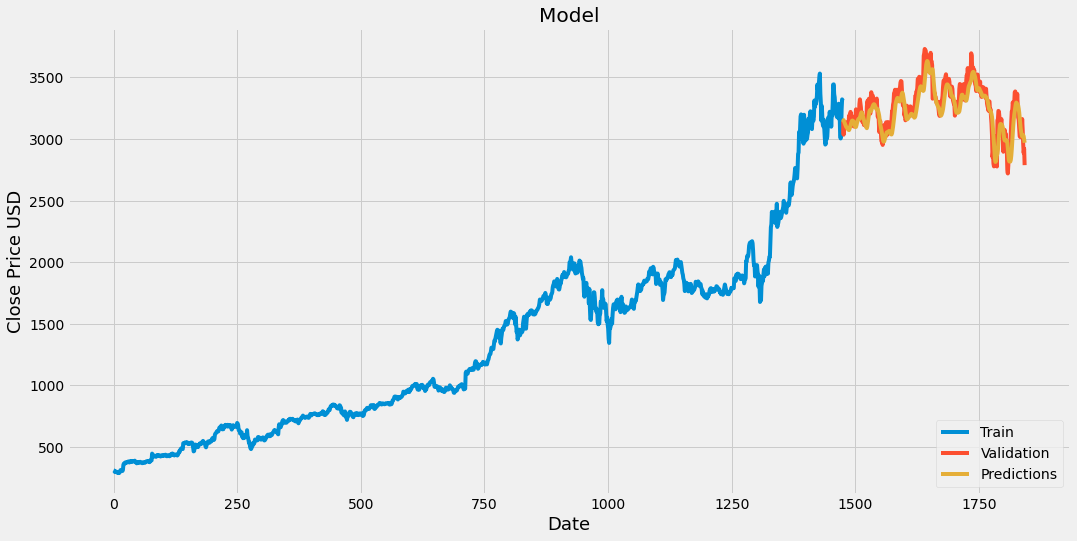

RMSE:  101.86053670461428
Normalised RMSE:  [0.10074032]


array([0.10074032])

In [33]:
plot_results(df, data, gridsearch_predictions)
rmse(gridsearch_predictions, y_test)

**Halving GRID SEARCH**


In [28]:
optimizer = ['RMSprop', 'Adam']
units = [16, 32, 64]
nb_epoch = [10, 20, 30]
batch_size = [50, 100]
dropout_rate = [0.1, 0.2, 0.3]

param_grid = dict(optimizer = optimizer, units=units, nb_epoch=nb_epoch, batch_size=batch_size, dropout_rate = dropout_rate)
Halfgrid = HalvingGridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, factor=3)

#start Timer
start_time = time.time()

Halfgrid_result = Halfgrid.fit(x_train, y_train)

#stop the timer
end_time = time.time()
total_time_sec = end_time - start_time
total_time_min = total_time_sec/60

print("Total time taken : ", total_time_sec)
print("Total time taken : ", total_time_min)

29/29 [==============================] - 8s 92ms/step - loss: 0.0964
Total time taken :  1164.4093039035797
Total time taken :  19.40682173172633


In [34]:
print("Best: %f using %s" % (Halfgrid_result.best_score_, Halfgrid_result.best_params_))

Best: -0.054021 using {'batch_size': 50, 'dropout_rate': 0.3, 'nb_epoch': 20, 'optimizer': 'RMSprop', 'units': 64}


In [39]:
means = Halfgrid_result.cv_results_['mean_test_score']
stds = Halfgrid_result.cv_results_['std_test_score']
params = Halfgrid_result.cv_results_['params']
print(len(params))
for mean, stdev, param in zip(means, stds, params):
  print("Mean = %f (std=%f) with: %r" %(mean, stdev, param))

162
Mean = -0.227695 (std=0.240052) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'RMSprop', 'units': 16}
Mean = -0.156496 (std=0.117493) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'RMSprop', 'units': 32}
Mean = -0.143562 (std=0.096712) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'RMSprop', 'units': 64}
Mean = -0.284284 (std=0.202921) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'Adam', 'units': 16}
Mean = -0.348419 (std=0.239021) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'Adam', 'units': 32}
Mean = -0.276656 (std=0.188950) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 10, 'optimizer': 'Adam', 'units': 64}
Mean = -0.294130 (std=0.179112) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch': 20, 'optimizer': 'RMSprop', 'units': 16}
Mean = -0.247227 (std=0.192426) with: {'batch_size': 50, 'dropout_rate': 0.1, 'nb_epoch'

In [43]:
model_HalfGridsearch = define_model(Halfgrid_result.best_params_['optimizer'], Halfgrid_result.best_params_['units'], Halfgrid_result.best_params_['dropout_rate'])
model_HalfGridsearch.fit(x_train, y_train, epochs=Halfgrid_result.best_params_['nb_epoch'], batch_size=Halfgrid_result.best_params_['batch_size'])
Halfgridsearch_predictions = predict(x_test, model_HalfGridsearch)

Epoch 1/20
29/29 [==============================] - 11s 89ms/step - loss: 0.0935
Epoch 2/20
29/29 [==============================] - 3s 88ms/step - loss: 0.0632
Epoch 3/20
29/29 [==============================] - 3s 89ms/step - loss: 0.0600
Epoch 4/20
29/29 [==============================] - 3s 89ms/step - loss: 0.0578
Epoch 5/20
29/29 [==============================] - 3s 87ms/step - loss: 0.0533
Epoch 6/20
29/29 [==============================] - 3s 89ms/step - loss: 0.0510
Epoch 7/20
29/29 [==============================] - 3s 89ms/step - loss: 0.0511
Epoch 8/20
29/29 [==============================] - 2s 82ms/step - loss: 0.0486
Epoch 9/20
29/29 [==============================] - 2s 85ms/step - loss: 0.0478
Epoch 10/20
29/29 [==============================] - 2s 82ms/step - loss: 0.0466
Epoch 11/20
29/29 [==============================] - 2s 79ms/step - loss: 0.0457
Epoch 12/20
29/29 [==============================] - 2s 78ms/step - loss: 0.0459
Epoch 13/20
29/29 [=================

C:\Users\sangh\AppData\Local\Temp\ipykernel_6508\1392178357.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


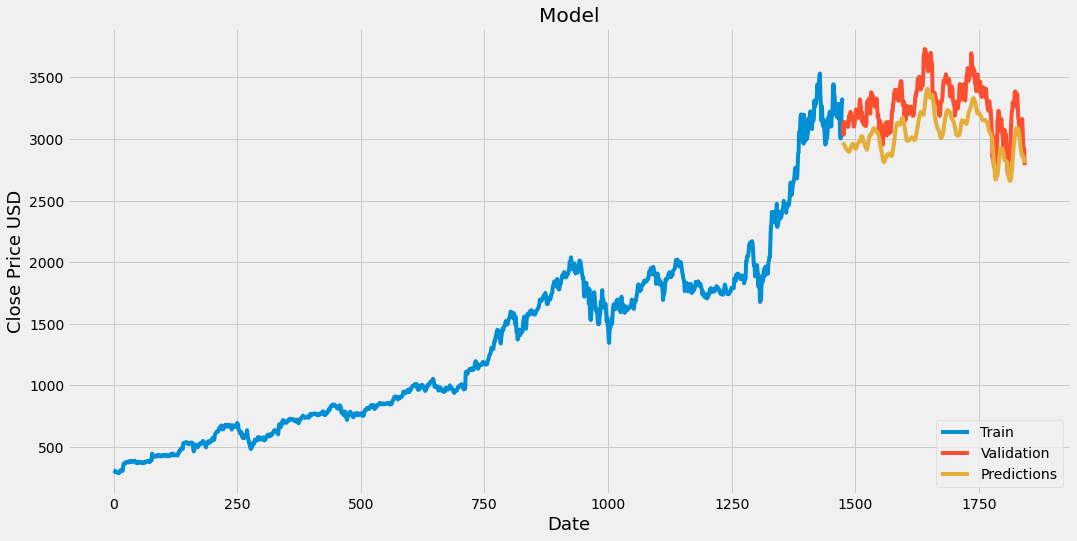

RMSE:  249.93220888413907
Normalised RMSE:  [0.24718356]


array([0.24718356])

In [44]:
plot_results(df, data, Halfgridsearch_predictions)
rmse(Halfgridsearch_predictions, y_test)



**RANDOM SEARCH**

In [23]:
optimizer = ['RMSprop', 'Adam']
units = [16, 32, 64]
nb_epoch = [10, 20, 30]
batch_size = [50, 100]
dropout_rate = [0.1, 0.2, 0.3]

param_grid = dict(optimizer = optimizer, units=units, nb_epoch=nb_epoch, batch_size=batch_size, dropout_rate = dropout_rate)
randomised = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, n_iter = 20)

#start Timer
start_time = time.time()

random_result = randomised.fit(x_train, y_train)

#stop the timer
end_time = time.time()
total_time_sec = end_time - start_time
total_time_min = total_time_sec/60

print("Total time taken : ", total_time_sec)
print("Total time taken : ", total_time_min)

29/29 [==============================] - 5s 33ms/step - loss: 0.1070
Total time taken :  165.63210439682007
Total time taken :  2.7605350732803347


In [24]:
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: -0.032628 using {'units': 16, 'optimizer': 'RMSprop', 'nb_epoch': 10, 'dropout_rate': 0.1, 'batch_size': 50}


In [25]:
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("Mean = %f (std=%f) with: %r" %(mean, stdev, param))

Mean = -0.099033 (std=0.040947) with: {'units': 16, 'optimizer': 'Adam', 'nb_epoch': 30, 'dropout_rate': 0.2, 'batch_size': 50}
Mean = -0.072507 (std=0.010176) with: {'units': 16, 'optimizer': 'RMSprop', 'nb_epoch': 10, 'dropout_rate': 0.2, 'batch_size': 50}
Mean = -0.109195 (std=0.054333) with: {'units': 16, 'optimizer': 'RMSprop', 'nb_epoch': 30, 'dropout_rate': 0.3, 'batch_size': 100}
Mean = -0.075486 (std=0.037212) with: {'units': 64, 'optimizer': 'RMSprop', 'nb_epoch': 10, 'dropout_rate': 0.2, 'batch_size': 50}
Mean = -0.108214 (std=0.045908) with: {'units': 16, 'optimizer': 'RMSprop', 'nb_epoch': 30, 'dropout_rate': 0.1, 'batch_size': 100}
Mean = -0.040903 (std=0.012998) with: {'units': 64, 'optimizer': 'RMSprop', 'nb_epoch': 10, 'dropout_rate': 0.1, 'batch_size': 100}
Mean = -0.096589 (std=0.027211) with: {'units': 64, 'optimizer': 'Adam', 'nb_epoch': 10, 'dropout_rate': 0.3, 'batch_size': 100}
Mean = -0.103262 (std=0.021173) with: {'units': 64, 'optimizer': 'Adam', 'nb_epoch': 

In [26]:
model_randomsearch = define_model(random_result.best_params_['optimizer'], random_result.best_params_['units'], random_result.best_params_['dropout_rate'])
model_randomsearch.fit(x_train, y_train, epochs=random_result.best_params_['nb_epoch'], batch_size=random_result.best_params_['batch_size'])
randomsearch_predictions = predict(x_test, model_randomsearch)

Epoch 1/10
29/29 [==============================] - 5s 38ms/step - loss: 0.1380
Epoch 2/10
29/29 [==============================] - 1s 37ms/step - loss: 0.0582
Epoch 3/10
29/29 [==============================] - 1s 38ms/step - loss: 0.0562
Epoch 4/10
29/29 [==============================] - 1s 39ms/step - loss: 0.0541
Epoch 5/10
29/29 [==============================] - 1s 37ms/step - loss: 0.0524
Epoch 6/10
29/29 [==============================] - 1s 41ms/step - loss: 0.0497
Epoch 7/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0466
Epoch 8/10
29/29 [==============================] - 1s 37ms/step - loss: 0.0469
Epoch 9/10
29/29 [==============================] - 1s 37ms/step - loss: 0.0443
Epoch 10/10
29/29 [==============================] - 1s 42ms/step - loss: 0.0454


C:\Users\sangh\AppData\Local\Temp\ipykernel_6508\1392178357.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


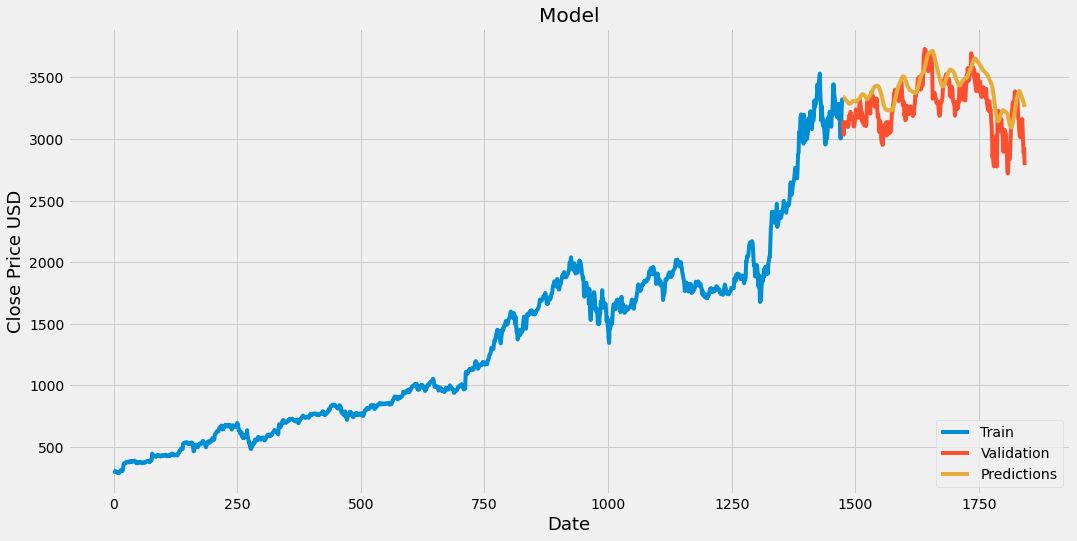

array([0.19003296])

RMSE:  192.14610198225043
Normalised RMSE:  [0.19003296]


In [27]:
plot_results(df, data, randomsearch_predictions)
rmse(randomsearch_predictions, y_test)

**Bayesian Search**

In [45]:
from skopt.searchcv import BayesSearchCV
from skopt.space import Integer, Real, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import accuracy_score

In [46]:
search_space = list()
search_space.append(Integer(16, 128, name='unit'))
search_space.append(Real(0.1, 0.5, name='dropout'))
search_space.append(Categorical(['rmsprop', 'adam'], name='optimizer'))
search_space.append(Integer(1, 10, name='epoch'))
search_space.append(Integer(1, 50, name='batch_size'))

In [47]:
def generate_model(unit, dropout, optimizer, epoch, batch_size):
  model = Sequential()
  model.add(LSTM(units=unit, return_sequences=True, input_shape = (x_train.shape[1], 1)))
  model.add(Dropout(dropout))
  model.add(LSTM(units=unit, return_sequences=False))
  model.add(Dropout(dropout))
  model.add(Dense(1))
  #compile the model
  model.compile(optimizer=optimizer, loss=root_mean_squared_error)
  model.fit(x_train, y_train, epochs=epoch, batch_size=batch_size, verbose = 0)
  return model

In [48]:
@use_named_args(search_space)
def evaluate_model(unit, dropout, optimizer, epoch, batch_size):
  model = Sequential()
  model.add(LSTM(units=unit, return_sequences=True, input_shape = (x_train.shape[1], 1)))
  model.add(Dropout(dropout))
  model.add(LSTM(units=unit, return_sequences=False))
  model.add(Dropout(dropout))
  model.add(Dense(1))
  #compile the model
  model.compile(optimizer=optimizer, loss=root_mean_squared_error)

  model.fit(x_train, y_train, epochs=epoch, batch_size=batch_size, verbose = 0)

  preds = model.predict(x_test)
  preds = scaler.inverse_transform(preds)
  rmse = np.sqrt(np.mean(preds - y_test)**2)
  print("Units = ",unit)
  print("dropout = ",dropout)
  print("Optimizer = ",optimizer)
  print("epoch = ",epoch)
  print("Batch size = ",batch_size)
  return rmse

In [49]:
# perform optimization
start_time = time.time()

result = gp_minimize(
    func=evaluate_model,
    dimensions=search_space,
    n_calls=10,
    verbose=True
)

print("Total time taken : --- %s seconds ---" % (time.time() - start_time))

Iteration No: 1 started. Evaluating function at random point.
Units =  54
dropout =  0.26889169310084476
Optimizer =  rmsprop
epoch =  5
Batch size =  25
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 16.7128
Function value obtained: 11.0064
Current minimum: 11.0064
Iteration No: 2 started. Evaluating function at random point.
Units =  126
dropout =  0.25951760448795647
Optimizer =  adam
epoch =  8
Batch size =  31
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 32.7888
Function value obtained: 77.4212
Current minimum: 11.0064
Iteration No: 3 started. Evaluating function at random point.
Units =  67
dropout =  0.332075974364251
Optimizer =  rmsprop
epoch =  9
Batch size =  15
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 38.5206
Function value obtained: 71.1917
Current minimum: 11.0064
Iteration No: 4 started. Evaluating function at random point.
Units =  88
dropout =  0.1493873324665686
Optimizer =  rmsprop
epoch =  7
Batc

In [50]:
print('Best Accuracy: %.3f' % (result.fun)) 
print('Best Parameters: %s' % (result.x))

Best Accuracy: 11.006
Best Parameters: [54, 0.26889169310084476, 'rmsprop', 5, 25]


C:\Users\sangh\AppData\Local\Temp\ipykernel_6508\1392178357.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


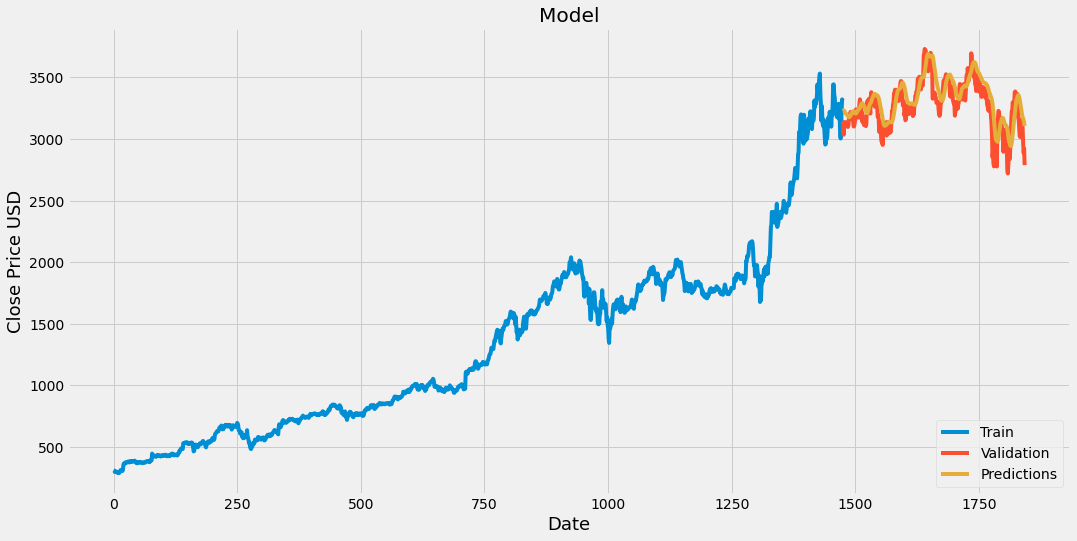

RMSE:  127.84558786934922
Normalised RMSE:  [0.1264396]


array([0.1264396])

In [53]:
bayes_model = generate_model(result.x[0], result.x[1], result.x[2], result.x[3], result.x[4])
bayes_predictions = predict(x_test, bayes_model)
plot_results(df, data, bayes_predictions)
rmse(bayes_predictions, y_test)


In [54]:
print("Gridsearch results-")
print("Best hyperparameters %s" % (grid_result.best_params_))
print("Best score %s" % (rmse(gridsearch_predictions, y_test)))
print("--------------------------------------------------------")
print("HalfGridsearch results-")
print("Best hyperparameters %s" % (Halfgrid_result.best_params_))
print("Best score %s" % (rmse(Halfgridsearch_predictions, y_test)))
print("--------------------------------------------------------")
print("Randomsearch results-")
print("Best hyperparameters %s" % (random_result.best_params_))
print("Best score %s" % (rmse(randomsearch_predictions, y_test)))
print("--------------------------------------------------------")
print("Bayessearch results-")
print("Best hyperparameters %s" % (result.x))
print("Best score %s" % (rmse(bayes_predictions, y_test)))
print("--------------------------------------------------------") 

Gridsearch results-
Best hyperparameters {'batch_size': 50, 'dropout_rate': 0.2, 'nb_epoch': 20, 'optimizer': 'RMSprop', 'units': 64}
RMSE:  101.86053670461428
Normalised RMSE:  [0.10074032]
Best score [0.10074032]
--------------------------------------------------------
HalfGridsearch results-
Best hyperparameters {'batch_size': 50, 'dropout_rate': 0.3, 'nb_epoch': 20, 'optimizer': 'RMSprop', 'units': 64}
RMSE:  249.93220888413907
Normalised RMSE:  [0.24718356]
Best score [0.24718356]
--------------------------------------------------------
Randomsearch results-
Best hyperparameters {'units': 16, 'optimizer': 'RMSprop', 'nb_epoch': 10, 'dropout_rate': 0.1, 'batch_size': 50}
RMSE:  192.14610198225043
Normalised RMSE:  [0.19003296]
Best score [0.19003296]
--------------------------------------------------------
Bayessearch results-
Best hyperparameters [54, 0.26889169310084476, 'rmsprop', 5, 25]
RMSE:  127.84558786934922
Normalised RMSE:  [0.1264396]
Best score [0.1264396]
-------------